# Apps Dataset

https://github.com/hendrycks/apps?tab=readme-ov-file

In [1]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

import os 
import sys

sys.path.append(os.path.join(os.getcwd(), "../../"))

import src.visualization.plot_rawdata as plotutils

In [2]:
from datasets import load_dataset

dataset = load_dataset("codeparrot/apps")
sum([len(dataset[elem]) for elem in dataset.keys()])

10000

In [3]:
dataset.keys()

dict_keys(['train', 'test'])

In [4]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [5]:
idx = 899
dataset['train'][idx]

{'problem_id': 899,
 'question': 'Chef wants to teach a lesson of sharing to the students.\nThere are $N$ students (numbered from $1$ to $N$ from left to right) who are asked to stand in a row. Initially Chef gave $A$$i$ candies to the $i$$th$ child. In one operation any child can give any number of candies to the child standing to his immediate left (i.e. $i$$th$ child can give any amount of candies to the $(i-1)$$th$ child. In particular 1st child cannot give his candies to anyone).  \nHe asked them to minimize the maximum value of candies a student can possess after performing any number of operations (possibly zero). \nHelp the students finding such maximum value.\n\n-----Input:-----\n- The first line of the input contains a single integer $T$ denoting the number of test cases. The description of $T$ test cases follows.\n- First line of each test case contains a single integer $N$ denoting the number of students.\n- Second line contains $N$ space-separated integers $A$$1$,$A$$2$,$.

In [6]:
dataset['train'][idx].keys()

dict_keys(['problem_id', 'question', 'solutions', 'input_output', 'difficulty', 'url', 'starter_code'])

In [7]:
dataset['test'][idx].keys()

dict_keys(['problem_id', 'question', 'solutions', 'input_output', 'difficulty', 'url', 'starter_code'])

In [8]:
print(f"The 'train' subset has {len(dataset['train'])} samples\nThe 'test' subset has {len(dataset['test'])} samples")

The 'train' subset has 5000 samples
The 'test' subset has 5000 samples


In [9]:
#Find the firt element that contains the 'starter_code'
for i, elem in enumerate(dataset['train']):
    if elem['input_output'] and elem['starter_code']:
        idx = i
        break

In [10]:
dataset['train'][idx]['starter_code']

'\nclass Solution:\n    def maxScore(self, cardPoints: List[int], k: int) -> int:\n        '

In [11]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

### For now, only consider the 'train' subset, as it has 5000 samples alone
We will take only 2000 samples

In [12]:
data = dataset['train']

In [13]:
type(data)

datasets.arrow_dataset.Dataset

In [14]:
len(data)

5000

#### Check if all elements in data are of type dict and if just one input prompt per data sample (no conversation)

In [15]:
verbose= False

keys = ['problem_id', 'question', 'solutions', 'input_output', 'difficulty', 'url', 'starter_code']

for i, elem in enumerate(data):
    if not isinstance(elem, dict):
        print(f"Elem is not a dict! {elem}")
    elif sorted(list(elem.keys())) != sorted(keys):
        print(f"Elem has different keys in dict! {elem.keys()}\n{elem}\n")
    if elem['input_output']:
        if type(elem['input_output']) != str:
            print(f"Input-Output of sample {i} of type {type(elem['input_output'])}")
        mydict = json.loads(data[idx]['input_output'])
        if type(mydict['inputs']) != list:
            print(f"Input-Output of sample {i} -- inputs NOT a list!")

In [16]:
data[idx]['input_output']

'{"fn_name": "maxScore", "inputs": [[[1, 2, 3, 4, 5, 6, 1], 3]], "outputs": [12]}'

#### Note that the 'input_output' variable is a string!
We need to convert it to a dict within the `rawprocessor.apps_generate_rawprompt_text` function 

In [17]:
mydict = json.loads(data[idx]['input_output'])

In [18]:
print(type(mydict))
print(mydict)

<class 'dict'>
{'fn_name': 'maxScore', 'inputs': [[[1, 2, 3, 4, 5, 6, 1], 3]], 'outputs': [12]}


In [19]:
len(mydict['inputs'])

1

### No data

In [20]:
no_conver_data = []

prompt_key = "question"

for elem in data: 
    if not elem[prompt_key]:
        no_conver_data.append(elem)
print(f"There are {len(no_conver_data)} elements in the dataset with no prompts!")

There are 0 elements in the dataset with no prompts!


So all of the elements in this dataset have an instruction!

#### Plot conversations lengths (number of tokens of first human input)

In [21]:
access_tk = os.getenv("HF_API_TOKEN")
device_str = "cuda:0"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
padding_side='left'

tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.float16, padding_side=padding_side)



## Input handling
Each sample in the dataset is of type `dict`.
The keys of that `dict` are `['problem_id', 'question', 'solutions', 'input_output', 'difficulty', 'url', 'starter_code']`. 

However, the tokenizers do not recognize those keyas, so we need to append it to the user's `content`.  

In [22]:
def get_tokens(sentence, tokenizer):
    return tokenizer.apply_chat_template(sentence, return_tensors="pt", add_generation_prompt=True)   

In [23]:
from src.data.rawdata_processor import apps_generate_rawprompt_text, build_rawprompt_text_chat, build_rawprompt_text_batch

In [24]:
mystring = apps_generate_rawprompt_text(data[idx], tokenizer, truncate=False, prompt_key=prompt_key)
print(mystring)

QUESTION: There are several cards arranged in a row, and each card has an associated number of points The points are given in the integer array cardPoints.
In one step, you can take one card from the beginning or from the end of the row. You have to take exactly k cards.
Your score is the sum of the points of the cards you have taken.
Given the integer array cardPoints and the integer k, return the maximum score you can obtain.
 
Example 1:
Input: cardPoints = [1,2,3,4,5,6,1], k = 3
Output: 12
Explanation: After the first step, your score will always be 1. However, choosing the rightmost card first will maximize your total score. The optimal strategy is to take the three cards on the right, giving a final score of 1 + 6 + 5 = 12.

Example 2:
Input: cardPoints = [2,2,2], k = 2
Output: 4
Explanation: Regardless of which two cards you take, your score will always be 4.

Example 3:
Input: cardPoints = [9,7,7,9,7,7,9], k = 7
Output: 55
Explanation: You have to take all the cards. Your score

In [25]:
build_rawprompt_text_chat(mystring)

[{'role': 'user',
  'content': 'QUESTION: There are several cards\xa0arranged in a row, and each card has an associated number of points\xa0The points are given in the integer array\xa0cardPoints.\nIn one step, you can take one card from the beginning or from the end of the row. You have to take exactly k cards.\nYour score is the sum of the points of the cards you have taken.\nGiven the integer array cardPoints and the integer k, return the maximum score you can obtain.\n\xa0\nExample 1:\nInput: cardPoints = [1,2,3,4,5,6,1], k = 3\nOutput: 12\nExplanation: After the first step, your score will always be 1. However, choosing the rightmost card first will maximize your total score. The optimal strategy is to take the three cards on the right, giving a final score of 1 + 6 + 5 = 12.\n\nExample 2:\nInput: cardPoints = [2,2,2], k = 2\nOutput: 4\nExplanation: Regardless of which two cards you take, your score will always be 4.\n\nExample 3:\nInput: cardPoints = [9,7,7,9,7,7,9], k = 7\nOutpu

In [26]:
get_tokens(build_rawprompt_text_chat(mystring), tokenizer)

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,    605,   3297,    220,   2366,     20,    271, 128009, 128006,
            882, 128007,    271,  53528,     25,   2684,    527,   3892,   7563,
           4194,   1138,   3811,    304,    264,   2872,     11,    323,   1855,
           3786,    706,    459,   5938,   1396,    315,   3585,   4194,    791,
           3585,    527,   2728,    304,    279,   7698,   1358,   4194,   5057,
          11665,    627,    644,    832,   3094,     11,    499,    649,   1935,
            832,   3786,    505,    279,   7314,    477,    505,    279,    842,
            315,    279,   2872,     13,   1472,    617,    311,   1935,   7041,
            597,   7563,    627,   7927,   5573,    374,    279,   2694,    315,
            279,   3585,    315,    279,   7563,    499,    617,   4529,    627,
          22818,    279,   7

In [27]:
print(tokenizer.decode(get_tokens(build_rawprompt_text_batch(mystring, 5), tokenizer)[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

QUESTION: There are several cards arranged in a row, and each card has an associated number of points The points are given in the integer array cardPoints.
In one step, you can take one card from the beginning or from the end of the row. You have to take exactly k cards.
Your score is the sum of the points of the cards you have taken.
Given the integer array cardPoints and the integer k, return the maximum score you can obtain.
 
Example 1:
Input: cardPoints = [1,2,3,4,5,6,1], k = 3
Output: 12
Explanation: After the first step, your score will always be 1. However, choosing the rightmost card first will maximize your total score. The optimal strategy is to take the three cards on the right, giving a final score of 1 + 6 + 5 = 12.

Example 2:
Input: cardPoints = [2,2,2], k = 2
Output: 4
Explanation: Regardless of 

### Estimate VERY LONG prompts
Our analysis found a problem instance that relates to factorial calculations, which yields a very long element in the `datasample['input_outpu']['output']` list that prevents it from being transformed to a Dict using json.  

Since its just ONE problem instance, we ignore it for now.

In [28]:
mylist = []
for i, elem in enumerate(data):
    try:
        mylist.append(build_rawprompt_text_chat(apps_generate_rawprompt_text(elem, tokenizer, truncate=False, prompt_key=prompt_key)))
    except ValueError:
        print(f"Error on element {i}")

Error on element 3028


#### Sicne its only one element, we ignore this element

In [29]:
# Index to exclude
index_to_remove = 3028

# Create a new dataset without the element at index 123
indices = list(range(len(data)))
indices.pop(index_to_remove)

data_new = data.select(indices)

In [30]:
len(data_new)

4999

### Analyze lenght of prompts in terms of number of tokens

In [31]:
conv_len_tokens = [get_tokens(build_rawprompt_text_chat(apps_generate_rawprompt_text(elem, tokenizer, truncate=False, prompt_key=prompt_key)), 
                              tokenizer).shape[1] for elem in data_new]

Token indices sequence length is longer than the specified maximum sequence length for this model (350708 > 131072). Running this sequence through the model will result in indexing errors


In [32]:
len(conv_len_tokens)

4999

In [33]:
np.max(conv_len_tokens)

np.int64(10489768)

In [34]:
print(f"MEAN: {np.mean(conv_len_tokens)}\nMIN: {np.min(conv_len_tokens)},\nMAX: {np.max(conv_len_tokens)}")
print(*[f"P{p}: {v:.2f}" for p, v in zip([25, 50, 75, 99], np.percentile(conv_len_tokens, [25, 50, 75, 99]))])

MEAN: 2990.245649129826
MIN: 76,
MAX: 10489768
P25: 312.00 P50: 446.00 P75: 655.50 P99: 2395.54


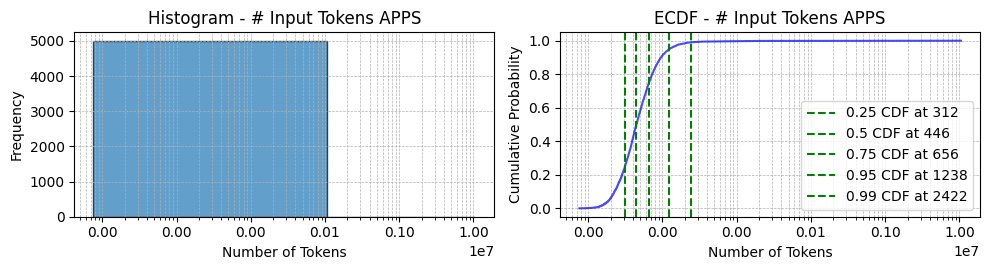

In [56]:
# fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(12, 2.8), 
#                              in_title="# Input Tokens APPS", x_forcdf=0, 
#                                        cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.99],
#                                       n_bins=80)
fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
                                       in_title="# Input Tokens APPS", n_bins=100, 
                                       x_forcdf=0, cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.99], logx=True)

In [36]:
fig.savefig("../../outputs/images/raw_data_APPS_COMPLETE_ntokens_hist.pdf", bbox_inches="tight")

## Convert dataset to pandas
Later, when splitting the datasets, we will have to stratify the splits based on the `difficulty` variable from each data sample. 
Converting the list of dicts to a pandas dataframe will facilitate the stratification of the splits. 

Moreover, after estimating the input tokens lengths, it will help us see the distribution of input token lengths according to `difficulty`. 

In [37]:
type(data_new)

datasets.arrow_dataset.Dataset

In [38]:
df_data = data_new.to_pandas()

In [39]:
df_data.head()

,problem_id,question,solutions,input_output,difficulty,url,starter_code
0,0,Polycarp has $n$ different binary words. A wor...,"[""for _ in range(int(input())):\n n = int(i...","{\n ""inputs"": [\n ""4\n4\n0001\n1000\n0011\...",interview,https://codeforces.com/problemset/problem/1259/D,
1,1,Mikhail walks on a Cartesian plane. He starts ...,"[""q=int(input())\n\nfor e in range(q):\n x,...","{\n ""inputs"": [\n ""3\n2 2 3\n4 3 7\n10 1 9...",interview,https://codeforces.com/problemset/problem/1036/B,
2,2,"You are given three sequences: $a_1, a_2, \ldo...","[""import sys\nimport random\nfrom fractions im...","{\n ""inputs"": [\n ""5\n3\n1 1 1\n2 2 2\n3 3...",interview,https://codeforces.com/problemset/problem/1408/A,
3,3,"You have $n$ barrels lined up in a row, number...","[""def solve():\n n, k = map(int,input().spl...","{\n ""inputs"": [\n ""2\n4 1\n5 5 5 5\n3 2\n0...",interview,https://codeforces.com/problemset/problem/1430/B,
4,4,"You are given a permutation $p=[p_1, p_2, \ldo...","[""for _ in range(int(input())):\n input()\n...","{\n ""inputs"": [\n ""3\n6\n4 5 1 3 2 6\n5\n5...",interview,https://codeforces.com/problemset/problem/1265/B,


#### Estimate the numer of input tokens

In [40]:
def get_tokens_row(row, tokenizer): 
    return get_tokens(build_rawprompt_text_chat(apps_generate_rawprompt_text(row, tokenizer, truncate=True)), tokenizer).shape[1]
    

In [41]:
df_data['n_tokens_input'] = df_data.apply(lambda row: get_tokens_row(row, tokenizer), axis=1)

Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.

In [42]:
df_data['n_tokens_input'].isna().any()

np.False_

In [43]:
df_data['difficulty'].unique()

array(['interview', 'competition', 'introductory'], dtype=object)

In [44]:
df_data.head()

,problem_id,question,solutions,input_output,difficulty,url,starter_code,n_tokens_input
0,0,Polycarp has $n$ different binary words. A wor...,"[""for _ in range(int(input())):\n n = int(i...","{\n ""inputs"": [\n ""4\n4\n0001\n1000\n0011\...",interview,https://codeforces.com/problemset/problem/1259/D,,818
1,1,Mikhail walks on a Cartesian plane. He starts ...,"[""q=int(input())\n\nfor e in range(q):\n x,...","{\n ""inputs"": [\n ""3\n2 2 3\n4 3 7\n10 1 9...",interview,https://codeforces.com/problemset/problem/1036/B,,773
2,2,"You are given three sequences: $a_1, a_2, \ldo...","[""import sys\nimport random\nfrom fractions im...","{\n ""inputs"": [\n ""5\n3\n1 1 1\n2 2 2\n3 3...",interview,https://codeforces.com/problemset/problem/1408/A,,1417
3,3,"You have $n$ barrels lined up in a row, number...","[""def solve():\n n, k = map(int,input().spl...","{\n ""inputs"": [\n ""2\n4 1\n5 5 5 5\n3 2\n0...",interview,https://codeforces.com/problemset/problem/1430/B,,584
4,4,"You are given a permutation $p=[p_1, p_2, \ldo...","[""for _ in range(int(input())):\n input()\n...","{\n ""inputs"": [\n ""3\n6\n4 5 1 3 2 6\n5\n5...",interview,https://codeforces.com/problemset/problem/1265/B,,1076


In [45]:
import importlib 
importlib.reload(plotutils)

<module 'src.visualization.plot_rawdata' from '/home/daniel/Documents/llm-testbed/data/notebooks/../../src/visualization/plot_rawdata.py'>

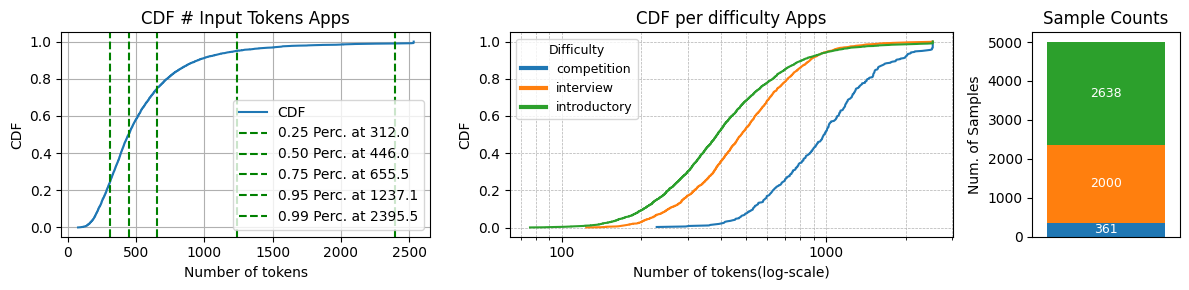

In [46]:
fig = plotutils.plot_appsdataframe_ecdf_threeplot(df_data, figsize=(12,3), title_suffix="Apps")

In [47]:
fig.savefig("../../outputs/images/raw_data_Apps_COMPLETE_ntokens_ecdf.pdf", bbox_inches="tight")

In [48]:
np.max(df_data['n_tokens_input'])

np.int64(2534)

# Split the datasets

We do stratified splits according to the `'difficulties'` variable of the data samples 

In [49]:
print(f"Length of records: {len(df_data)}")
df_data.head()

Length of records: 4999


,problem_id,question,solutions,input_output,difficulty,url,starter_code,n_tokens_input
0,0,Polycarp has $n$ different binary words. A wor...,"[""for _ in range(int(input())):\n n = int(i...","{\n ""inputs"": [\n ""4\n4\n0001\n1000\n0011\...",interview,https://codeforces.com/problemset/problem/1259/D,,818
1,1,Mikhail walks on a Cartesian plane. He starts ...,"[""q=int(input())\n\nfor e in range(q):\n x,...","{\n ""inputs"": [\n ""3\n2 2 3\n4 3 7\n10 1 9...",interview,https://codeforces.com/problemset/problem/1036/B,,773
2,2,"You are given three sequences: $a_1, a_2, \ldo...","[""import sys\nimport random\nfrom fractions im...","{\n ""inputs"": [\n ""5\n3\n1 1 1\n2 2 2\n3 3...",interview,https://codeforces.com/problemset/problem/1408/A,,1417
3,3,"You have $n$ barrels lined up in a row, number...","[""def solve():\n n, k = map(int,input().spl...","{\n ""inputs"": [\n ""2\n4 1\n5 5 5 5\n3 2\n0...",interview,https://codeforces.com/problemset/problem/1430/B,,584
4,4,"You are given a permutation $p=[p_1, p_2, \ldo...","[""for _ in range(int(input())):\n input()\n...","{\n ""inputs"": [\n ""3\n6\n4 5 1 3 2 6\n5\n5...",interview,https://codeforces.com/problemset/problem/1265/B,,1076


#### First, sample a subset of the data

In [50]:
SEED = 42
MAXIMUM = 2000

In [51]:
# Stratified sampling of 2000 samples from the full dataset
df_sampled, _ = train_test_split(df_data, train_size=2000, stratify=df_data['difficulty'], random_state=SEED)

In [52]:
print(f"Length of records: {len(df_sampled)}")

Length of records: 2000


In [53]:
print(f"MEAN: {np.mean(df_sampled["n_tokens_input"])}\nMIN: {np.min(df_sampled["n_tokens_input"])},\nMAX: {np.max(df_sampled["n_tokens_input"])}")
print(*[f"P{p}: {v:.2f}" for p, v in zip([25, 50, 75, 99], np.percentile(df_sampled["n_tokens_input"], [25, 50, 75, 99]))])

MEAN: 545.0165
MIN: 87,
MAX: 2534
P25: 307.75 P50: 441.00 P75: 650.00 P99: 2105.53


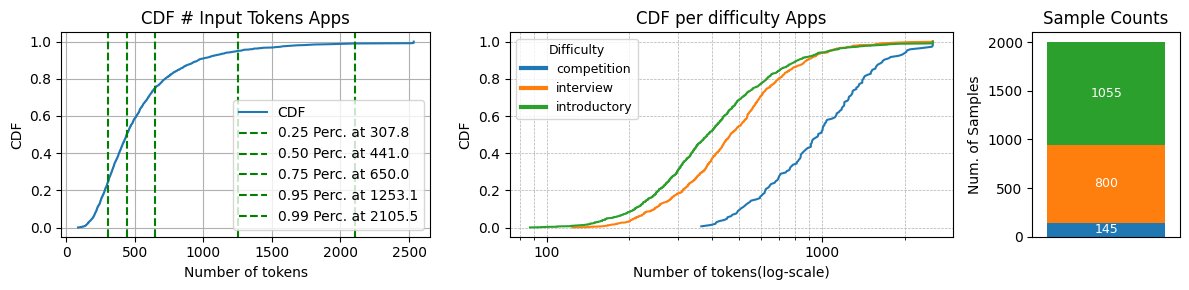

In [54]:
fig = plotutils.plot_appsdataframe_ecdf_threeplot(df_sampled, figsize=(12,3), title_suffix="Apps")

In [55]:
fig.savefig("../../outputs/images/raw_data_Apps_ntokens_ecdf.pdf", bbox_inches="tight")

#### Now, do the train-validation-test splits

In [57]:
if 'n_tokens_input' in df_sampled.columns: 
    df_sampled = df_sampled.drop(columns=['n_tokens_input'])

In [58]:
df_sampled.head()

,problem_id,question,solutions,input_output,difficulty,url,starter_code
3382,3383,Is the number even?\n\nIf the numbers is even ...,"[""def is_even(n):\n return not n & 1"", ""def...","{""fn_name"": ""is_even"", ""inputs"": [[2], [3], [1...",introductory,https://www.codewars.com/kata/592a33e549fe9840...,\ndef is_even(n):\n\t
3900,3901,"In this Kata, you will be given a ```number```...","[""def check_digit(n, idx1, idx2, digit):\n ...","{""fn_name"": ""check_digit"", ""inputs"": [[1234567...",introductory,https://www.codewars.com/kata/5a2e8c0955519e54...,"\ndef check_digit(number, index1, index2, digi..."
3868,3869,# Task\n Below we will define what and n-inter...,"[""def shape_area(n):\n return n**2 + (n - 1...","{""fn_name"": ""shape_area"", ""inputs"": [[2], [3],...",introductory,https://www.codewars.com/kata/5893e0c41a88085c...,\ndef shape_area(n):\n\t
2286,2286,In Finite Encyclopedia of Integer Sequences (F...,"[""k,n = map(int,input().split())\nif k %2 ==0:...","{""inputs"": [""3 2\n"", ""2 4\n"", ""5 14\n""], ""outp...",competition,https://atcoder.jp/contests/arc084/tasks/arc084_c,
2111,2111,Lesha plays the recently published new version...,"[""import itertools\nimport bisect\n\nn, A, cf,...","{\n ""inputs"": [\n ""3 5 10 1 5\n1 3 1\n"",\n...",competition,https://codeforces.com/problemset/problem/613/B,


In [59]:
df_train, df_tmp = train_test_split(df_sampled, test_size=0.3, stratify=df_sampled['difficulty'], random_state=SEED)

In [60]:
df_validate, df_test = train_test_split(df_tmp, test_size=1/3, stratify=df_tmp['difficulty'], random_state=SEED)

In [61]:
print(f"Percentage of training data: {round(len(df_train)/len(df_sampled), 4)}")
print(f"Percentage of validation data: {round(len(df_validate)/len(df_sampled), 4)}")
print(f"Percentage of test data: {round(len(df_test)/len(df_sampled), 4)}")

Percentage of training data: 0.7
Percentage of validation data: 0.2
Percentage of test data: 0.1


In [62]:
len(df_train)

1400

### Convert to list of dicts

In [63]:
data_train = df_train.to_dict(orient='records')
data_val = df_validate.to_dict(orient='records')
data_test = df_test.to_dict(orient='records')

In [64]:
# Check if the lengths agree
print(f"Percentage of training data: {round(len(data_train)/len(data), 4)}")
print(f"Percentage of validation data: {round(len(data_val)/len(data), 4)}")
print(f"Percentage of test data: {round(len(data_test)/len(data), 4)}")

Percentage of training data: 0.28
Percentage of validation data: 0.08
Percentage of test data: 0.04


#### Check that compatibility still holds for `rawprompt`` builder function 

In [65]:
elem = data_train[1]
print(apps_generate_rawprompt_text(elem, tokenizer, truncate=True, prompt_key=prompt_key))

You are an expert Python programmer. QUESTION: You may be familiar with the concept of combinations: for example, if you take 5 cards from a 52 cards deck as you would playing poker, you can have a certain number (2,598,960, would you say?) of different combinations.

In mathematics the number of *k* combinations you can have taking from a set of *n* elements is called the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient) of n and k, more popularly called **n choose k**.

The formula to compute it is relatively simple: `n choose k`==`n!/(k!*(n-k)!)`, where `!` of course denotes the factorial operator.

You are now to create a choose function that computes the binomial coefficient, like this:

```
choose(1,1)==1
choose(5,4)==5
choose(10,5)==252
choose(10,20)==0
choose(52,5)==2598960
```

Be warned: a certain degree of optimization is expected, both to deal with larger numbers precision (and their rounding errors in languages like JS) and computing time.

Your co

In [66]:
conv_len_tokens = [get_tokens(build_rawprompt_text_chat(apps_generate_rawprompt_text(elem, tokenizer, truncate=True, prompt_key=prompt_key)), 
                              tokenizer).shape[1] for elem in data_train + data_val + data_test]

Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.
Prompt text length exceeds maximum limit of 2500 tokens. Truncarting prompt.

## Save data

In [67]:
def save_data(dataset, path):
    with open(path, 'w') as f:
        json.dump(dataset, f)
    print(f"Dataset saved to path {path}")

In [68]:
save_path_src = "../raw_instruct/Apps/raw_Apps"

In [69]:
save_data(data_train, save_path_src + "_train.json")

Dataset saved to path ../raw_instruct/Apps/raw_Apps_train.json


In [70]:
save_data(data_val, save_path_src + "_validate.json")

Dataset saved to path ../raw_instruct/Apps/raw_Apps_validate.json


In [71]:
save_data(data_test, save_path_src + "_test.json")

Dataset saved to path ../raw_instruct/Apps/raw_Apps_test.json


# BACKUP CELLS

#### First, make sure the type of the `input_output`column is Dict and not String

In [ ]:
type(df_data.iloc[idx]["input_output"])

In [78]:
for i, val in enumerate(df_data["input_output"]):
    try:
        json.loads(val)
    except Exception as e:
        print(f"Row {i} failed with error: {e}")
        print("Offending value:", repr(val))

Row 1805 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1806 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1807 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1808 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1809 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1810 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1811 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1812 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1813 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1814 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1815 failed with error: Expecting value: line 1 column 1 (char 0)
Offending value: ''
Row 1816 f

In [74]:
df_data.iloc[1805]

problem_id                                                     1805
question          There are n people, each person has a unique i...
solutions         ["class Solution:\n    def watchedVideosByFrie...
input_output                                                       
difficulty                                                interview
url               https://leetcode.com/problems/get-watched-vide...
starter_code      \nclass Solution:\n    def watchedVideosByFrie...
n_tokens_input                                                  577
Name: 1805, dtype: object

In [ ]:
def safe_json_loads(x):
    if isinstance(x, str) and x.strip():
        try:
            return json.loads(x)
        except json.JSONDecodeError:
            return None
    return None  # for NaN, None, or empty strings

In [ ]:
df_data["input_output"] = df_data["input_output"].apply(safe_json_loads)

In [ ]:
df_data.head()

In [ ]:
type(df_data.iloc[idx]["input_output"])

In [ ]:
if df_data.iloc[1805]["input_output"]:
    print("Hello!")